In [64]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
# from tensorflow.keras.callbacks import EarlyStopping

  Preparing metadata (setup.py) ... done
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [65]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2023-12-28 05:19:06--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv.4’

insurance.csv.4     100%[===================>]  49.09K  --.-KB/s    in 0.007s  

2023-12-28 05:19:06 (6.88 MB/s) - ‘insurance.csv.4’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [66]:
# Avoid repeated and unnecessary importations of the dataset
# from fCC's Static Assets.
df = dataset.copy()
df.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [67]:
# Any necessity to impute any value?
df.isna()\
  .sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

In [68]:
# One-hot encode categorical values to be parsed as numerical ones
categoricals = ['sex',
                'smoker',
                'region']
df = pd.get_dummies(dataset,
                    columns = categoricals,
                    drop_first = True)

df.head()

,age,bmi,children,expenses,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.9,0,16884.92,0,1,0,0,1
1,18,33.8,1,1725.55,1,0,0,1,0
2,28,33.0,3,4449.46,1,0,0,1,0
3,33,22.7,0,21984.47,1,0,1,0,0
4,32,28.9,0,3866.86,1,0,1,0,0


In [69]:
# For the train dataset, create a random sample which contains 80% of the observations
train_dataset = df.sample(frac = .8,
                          random_state = 0)

# Assign the test dataset
test_dataset = df.drop(train_dataset.index)

# Pop off the 'expenses' colmuns
train_labels = train_dataset.pop('expenses')
test_labels = test_dataset.pop('expenses')


In [70]:
# Add output layers
input_shape = len(train_dataset.keys())

model = keras.Sequential(
    [
    layers.Dense(128,
                 activation = 'relu',
                 input_shape = [input_shape]),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(32, activation = 'relu'),
    layers.Dense(16, activation = 'relu'),
    layers.Dense(1, activation = 'relu')
  ]
    )

# Compile the model:
# Implement an 'Adaptive Moment Estimation' algorithm
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

optimizer = tf.keras.optimizers.Adam(
    learning_rate = .008
)

model.compile(loss = 'mae',
              optimizer = optimizer,
              metrics = ['mae','mse'])

model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 128)               1152      
                                                                 
 dense_43 (Dense)            (None, 64)                8256      
                                                                 
 dense_44 (Dense)            (None, 64)                4160      
                                                                 
 dense_45 (Dense)            (None, 32)                2080      
                                                                 
 dense_46 (Dense)            (None, 16)                528       
                                                                 
 dense_47 (Dense)            (None, 1)                 17        
                                                                 
Total params: 16193 (63.25 KB)
Trainable params: 16193

In [76]:

# Trian the model
# https://keras.io/api/callbacks/model_checkpoint/:

EPOCHS = 500
checkpoint_filepath = './tmp/ckpt/fcchealthcosts.model.keras'

checkpoint_callback  = [tf.keras.callbacks\
                        .ModelCheckpoint(filepath = checkpoint_filepath,
                                         monitor = 'val_loss',
                                         verbose = 1,
                                         save_best_only = True,
                                         mode = 'min'
                                         )
]
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History:
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit:

history = model.fit(train_dataset,
                    train_labels,
                    epochs = EPOCHS,
                    verbose = 1,
                    validation_split = .2,
                    shuffle = False,
                    callbacks = checkpoint_callback
)


Epoch 1/500
23/27 [========================>.....] - ETA: 0s - loss: 1547.2360 - mae: 1547.2360 - mse: 18566160.0000
Epoch 1: val_loss improved from inf to 1746.26208, saving model to ./tmp/ckpt/fcchealthcosts.model.keras
27/27 [==============================] - 0s 14ms/step - loss: 1632.2297 - mae: 1632.2297 - mse: 20224076.0000 - val_loss: 1746.2621 - val_mae: 1746.2621 - val_mse: 22509900.0000
Epoch 2/500
 8/27 [=======>......................] - ETA: 0s - loss: 1561.5537 - mae: 1561.5537 - mse: 17442662.0000
Epoch 2: val_loss did not improve from 1746.26208
27/27 [==============================] - 0s 6ms/step - loss: 1569.2274 - mae: 1569.2274 - mse: 19557758.0000 - val_loss: 1766.1056 - val_mae: 1766.1056 - val_mse: 22806028.0000
Epoch 3/500
20/27 [=====================>........] - ETA: 0s - loss: 1562.3274 - mae: 1562.3274 - mse: 19037714.0000
Epoch 3: val_loss did not improve from 1746.26208
27/27 [==============================] - 0s 5ms/step - loss: 1578.4083 - mae: 1578.4083 -

9/9 - 0s - loss: 2081.7781 - mae: 2081.7781 - mse: 33523188.0000 - 24ms/epoch - 3ms/step
Testing set Mean Abs Error: 2081.78 expenses
You passed the challenge. Great job!
9/9 [==============================] - 0s 1ms/step


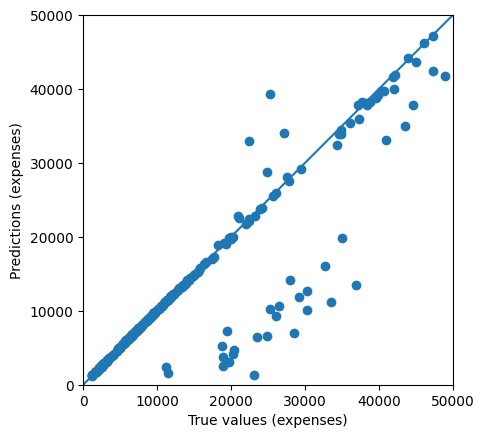

In [77]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)


In [73]:
# Compute some descriptive statistics of the test dataset
test_descript_stats = test_dataset.describe()\
                           .transpose()\
                           .round(3)
test_descript_stats

,count,mean,std,min,25%,50%,75%,max
age,268.0,39.888,13.680,18.0,28.0,40.0,52.000,64.0
bmi,268.0,30.379,6.232,17.4,26.0,30.1,34.125,48.1
children,268.0,1.101,1.184,0.0,0.0,1.0,2.000,5.0
sex_male,268.0,0.534,0.500,0.0,0.0,1.0,1.000,1.0
smoker_yes,268.0,0.228,0.420,0.0,0.0,0.0,0.000,1.0
region_northwest,268.0,0.272,0.446,0.0,0.0,0.0,1.000,1.0
region_southeast,268.0,0.235,0.425,0.0,0.0,0.0,0.000,1.0
region_southwest,268.0,0.276,0.448,0.0,0.0,0.0,1.000,1.0
